In [1]:
import sys
sys.path.append('/Users/sdkolak/anaconda3/envs/hector/lib/python3.9/site-packages')

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [113]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    print("This is size of original image:",image.size, "\n")
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


#style_img = image_loader("images/picasso.jpg")
#content_img = image_loader("images/dancing.jpg")

style_img = image_loader("images/mother-and-child-1.jpg")
content_img = image_loader("images/pieta.jpg")


print("style size", style_img.size())
print("content size", content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

This is size of original image: (607, 607) 

This is size of original image: (1500, 1500) 

style size torch.Size([1, 3, 128, 128])
content size torch.Size([1, 3, 128, 128])


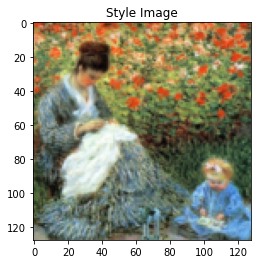

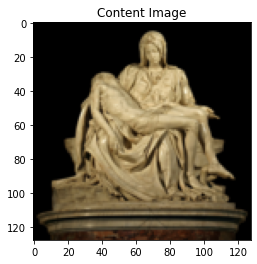

In [114]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [115]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [116]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [117]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [118]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [119]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [120]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

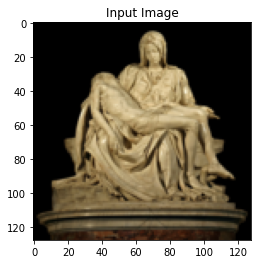

In [121]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [122]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [123]:
from torchvision.utils import save_image

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)
        
        print(input_img.size())
        x = input_img.clone()
        with torch.no_grad():
            x.clamp_(0, 1)
        #x = torch.randn(32, 1, 3, 3)
        transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(size=1024),
                transforms.ToTensor()
                ])
        x = [transform(x_) for x_ in x]
        #print(x.size())
        save_image(x, 'layer-outputs/output-resize'+str(run[0])+'.png')
        
        plt.figure()
        imshow(input_img, title='Output Image'+str(run[0]))

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


/var/folders/42/8_0pl3sd13zgt0n9z_j4_5sm0000gr/T/ipykernel_84056/1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/42/8_0pl3sd13zgt0n9z_j4_5sm0000gr/T/ipykernel_84056/1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
torch.Size([1, 3, 128, 128])


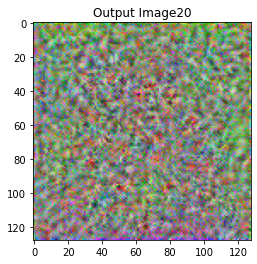

torch.Size([1, 3, 128, 128])


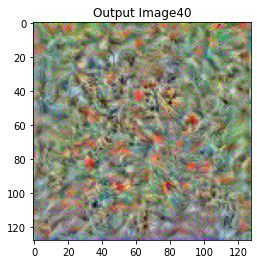

run [50]:
Style Loss : 166.143982 Content Loss: 56.590996

torch.Size([1, 3, 128, 128])


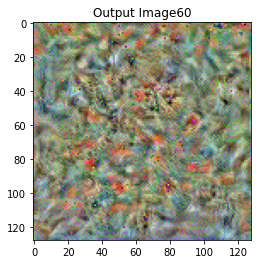

torch.Size([1, 3, 128, 128])


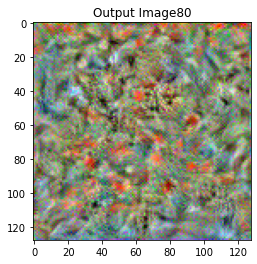

run [100]:
Style Loss : 42.764774 Content Loss: 53.649837

torch.Size([1, 3, 128, 128])


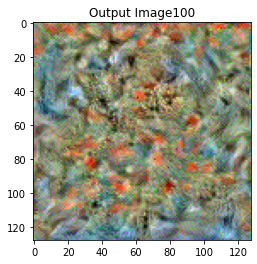

torch.Size([1, 3, 128, 128])


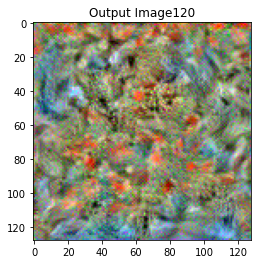

torch.Size([1, 3, 128, 128])


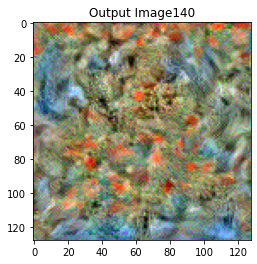

run [150]:
Style Loss : 19.564926 Content Loss: 49.038502

torch.Size([1, 3, 128, 128])


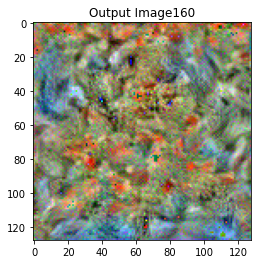

torch.Size([1, 3, 128, 128])


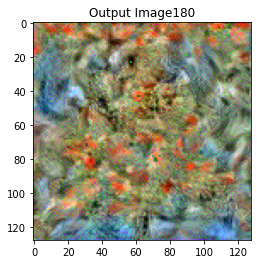

run [200]:
Style Loss : 12.846706 Content Loss: 44.681519

torch.Size([1, 3, 128, 128])


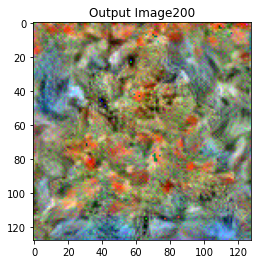

torch.Size([1, 3, 128, 128])


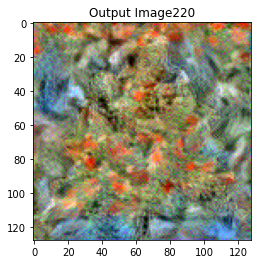

torch.Size([1, 3, 128, 128])


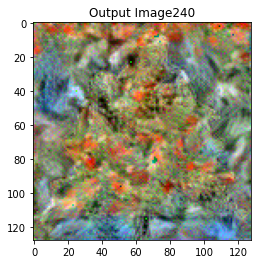

run [250]:
Style Loss : 10.082389 Content Loss: 41.213005

torch.Size([1, 3, 128, 128])


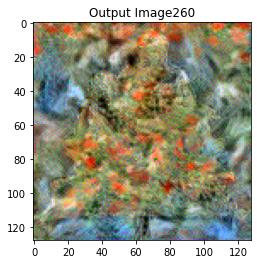

torch.Size([1, 3, 128, 128])


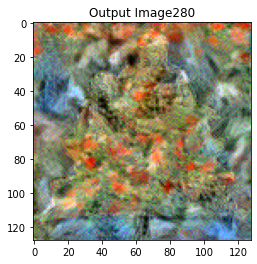

run [300]:
Style Loss : 8.578653 Content Loss: 38.407299

torch.Size([1, 3, 128, 128])


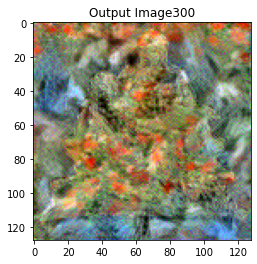

torch.Size([1, 3, 128, 128])


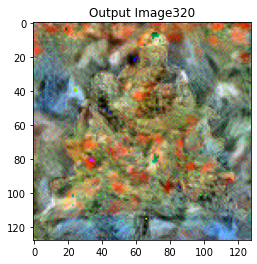

torch.Size([1, 3, 128, 128])


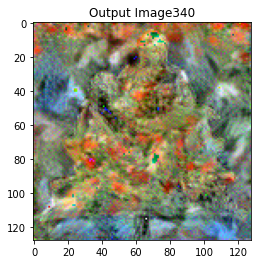

run [350]:
Style Loss : 7.523885 Content Loss: 36.345268

torch.Size([1, 3, 128, 128])


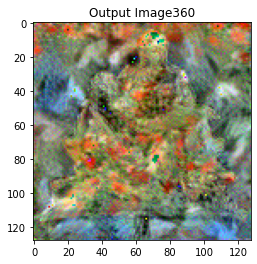

torch.Size([1, 3, 128, 128])


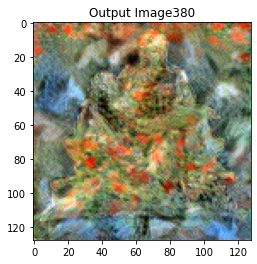

run [400]:
Style Loss : 6.828202 Content Loss: 34.774292

torch.Size([1, 3, 128, 128])


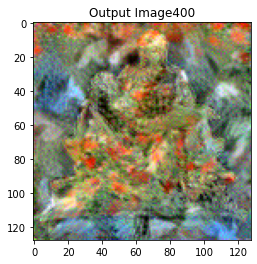

torch.Size([1, 3, 128, 128])


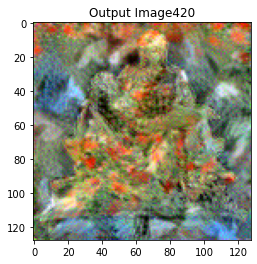

torch.Size([1, 3, 128, 128])


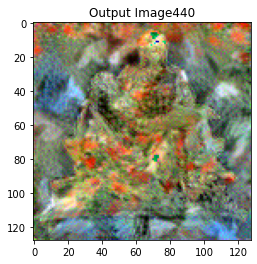

run [450]:
Style Loss : 6.263575 Content Loss: 33.586472

torch.Size([1, 3, 128, 128])


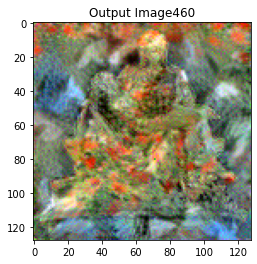

torch.Size([1, 3, 128, 128])


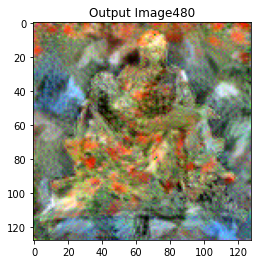

run [500]:
Style Loss : 5.847393 Content Loss: 32.665825

torch.Size([1, 3, 128, 128])


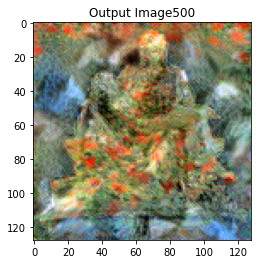

torch.Size([1, 3, 128, 128])


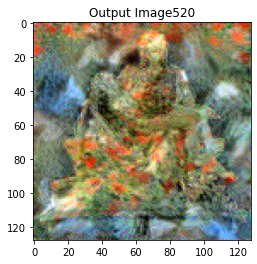

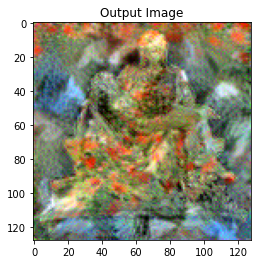

In [124]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()



In [125]:
x = output.clone()
with torch.no_grad():
    x.clamp_(0, 1)
#x = torch.randn(32, 1, 3, 3)
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=1024),
        transforms.ToTensor()
        ])
x = [transform(x_) for x_ in x]

save_image(x, 'images/last_out_more_blur.png')